In [1]:
"""
An implementation of Radial Basis Function(RBF) Neural Networks
for fault pattern identification,
for Fault Detection and Identification Course, KNTU, Spring 2023.

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2023-05-20: Initial coding
"""

In [ ]:
import torch
import torch.nn as nn                                    # All neural network modules
import torch.nn.functional as F                          # Parameterless functions, like activation functions
from torch import optim                                  # For optimizers like SGD, Adam, etc.
from torch.utils.data import Dataset, DataLoader         # dataset managment by creating mini batches etc.
import numpy as np
import matplotlib.pyplot as plt                          # for plotting!
from tqdm import tqdm                                    # For progress bar!
import seaborn as sn

In [ ]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 15.4 MB/s eta 0:00:00


## Generating a simple dataset

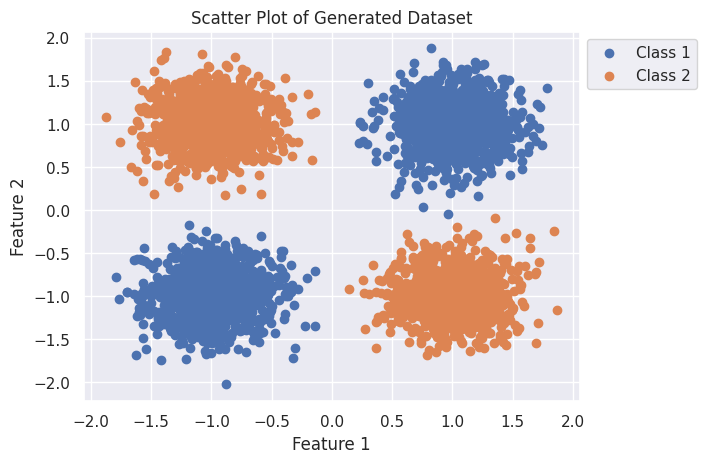

In [ ]:
mean1 = [1, 1]
mean2 = [-1, -1]
mean3 = [1, -1]
mean4 = [-1, 1]
cov = [[0.07, 0], [0, 0.07]]  # diagonal covariance

x1 = np.random.multivariate_normal(mean1, cov, 1000)
x2 = np.random.multivariate_normal(mean2, cov, 1000)
x3 = np.random.multivariate_normal(mean3, cov, 1000)
x4 = np.random.multivariate_normal(mean4, cov, 1000)

x = np.concatenate((x1, x2, x3, x4), axis=0)   # all dataset
y = np.zeros((4000))   # all labels
y[2000:] = 1

z1 = np.concatenate((x1, x2), axis=0)
z2 = np.concatenate((x3, x4), axis=0)

sn.set_theme(style="darkgrid")
plt.scatter(z1[:, 0], z1[:, 1])
plt.scatter(z2[:, 0], z2[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Generated Dataset")
plt.legend(['Class 1', 'Class 2'], ncol=1, bbox_to_anchor=(1., 1.0), loc='upper left')
plt.show()

## Custom dataset class

In [ ]:
class XORdataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.long)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

ds = XORdataset(x, y)
print(len(ds))
print(ds[0][0], ds[0][1])

4000
tensor([0.4985, 1.2655]) tensor(0)


## Breif review of RBF Neural Network and implementing RBF in PyTorch

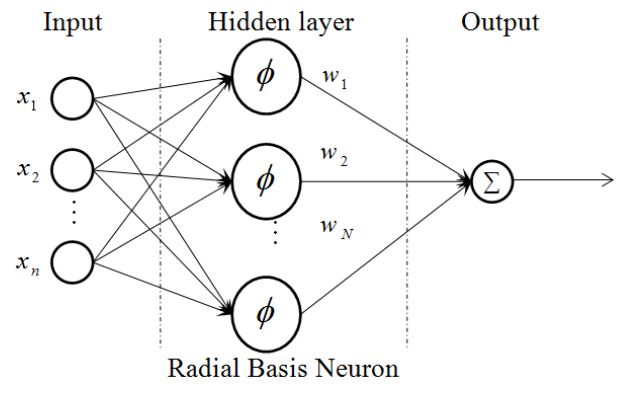

## Defining RBF Neural Network class

In [ ]:
class RBF_Layer(nn.Module):   # Implementation of RBF Layer
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})

    Arguments:
        in_features: size of each input sample
        num_kernels: number of kernels

    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, num_kernels) where N is an arbitrary batch size

    Attributes:
        centres: the learnable centres of shape (num_kernels, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.

        log_sigmas: logarithm of the learnable scaling factors of shape (num_kernels).

        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, num_kernels, basis_func):
        super(RBF_Layer, self).__init__()
        self.eps = torch.tensor(1e-8)
        self.centers = nn.Parameter(torch.Tensor(num_kernels, in_features))
        self.log_sigmas = nn.Parameter(torch.Tensor(num_kernels))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centers, 0, 1)
        nn.init.constant_(self.log_sigmas, 0)

    def compute_distance_vectorized(self, x_test):
        """
        Can be tricky to understand this, we utilize heavy
        vecotorization as well as numpy broadcasting.
        Idea: if we have two vectors a, b (two examples)
        and for vectors we can compute (a-b)^2 = a^2 - 2a (dot) b + b^2
        expanding on this and doing so for every vector lends to the
        heavy vectorized formula for all examples at the same time.
        """
        x_test_squared = torch.sum(x_test ** 2, axis=1, keepdims=True)
        centers_squared = torch.sum(self.centers ** 2, axis=1, keepdims=True)
        two_x_test_centers = torch.matmul(x_test, self.centers.T)

        return torch.sqrt(
            self.eps + x_test_squared - 2 * two_x_test_centers + centers_squared.T
        )

    def forward(self, x):
        distances = self.compute_distance_vectorized(x) / torch.exp(self.log_sigmas).unsqueeze(0)
        return self.basis_func(distances)

# RBF Kernels
def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

##### A simple test of RBF Layer

In [ ]:
# # RBF layer test
# rbf = RBF_Layer(25, 5, gaussian)
# input = torch.rand(64, 25)
# output = rbf(input)
# print(output.shape)

In [ ]:
class RBF_Network(nn.Module):
    def __init__(self, in_features, num_kernels, num_classes, basis_func):
        super(RBF_Network, self).__init__()
        self.rbf_net = nn.Sequential(RBF_Layer(in_features, num_kernels, basis_func),
                                     nn.Linear(num_kernels, num_classes)
                                     )

    def forward(self, x):
        return self.rbf_net(x)

##### A simple test of RBF Network

In [ ]:
# # RBF network test
# rbf = RBF_Network(2, 25, 2, gaussian)
# input = torch.rand(64, 2)
# output = rbf(input)
# print(output.shape)

## Setting hyperparameters and instanciating RBF Neural Network

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 4e-3
batch_size = 64
num_epochs = 50
in_features = 2
num_kernels = 5
num_classes = 2
basis_func = gaussian

model = RBF_Network(in_features, num_kernels, num_classes, basis_func).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Instanciating custom dataset

In [ ]:
dataset = XORdataset(x, y)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

## Defining useful function for training procedure


In [ ]:
def get_info(model, loader):
  batch_loss = []
  epoch_loss = []
  temp_loss = []
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for (data, targets) in loader:
      # Get data to device
      data = data.to(device=device)
      targets = targets.to(device=device)

      # Forward
      logits = model(data)
      _, predictions = logits.max(1)
      loss = criterion(logits, targets)

      # Taking record of losses
      batch_loss.append(loss.item())

      # Check how many we got correct
      num_correct += (predictions == targets).sum()
      # Keep track of number of samples
      num_samples += predictions.size(0)
  model.train()
  return (num_correct/num_samples).item(), sum(batch_loss)/len(batch_loss)

In [ ]:
# Train Network
def Train(model, device, criterion, optimizer, num_epochs):
  train_loss = []
  validation_loss = []
  train_acc = []
  validation_acc = []
  for epoch in range(num_epochs):
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to device
          data = data.to(device=device)
          targets = targets.to(device=device)

          # Forward
          logits = model(data)
          loss = criterion(logits, targets)

          # Backward
          optimizer.zero_grad()
          loss.backward()

          # Gradient descent or adam step
          optimizer.step()

      # Taking record of losses
      tr_acc, tr_loss = get_info(model, train_loader)
      val_acc, val_loss = get_info(model, validation_loader)
      train_loss.append(tr_loss)
      validation_loss.append(val_loss)
      train_acc.append(tr_acc)
      validation_acc.append(val_acc)

  plt.figure(figsize=(10, 6))
  #plot 1:
  plt.subplot(1, 2, 1)
  plt.plot(train_acc)
  plt.plot(validation_acc)
  plt.title("Accuracy")
  plt.legend(['Train Accuracy', 'Validation Accuracy'])
  #plot 2:
  plt.subplot(1, 2, 2)
  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title("Loss")
  plt.legend(['Train Loss', 'Validation Loss'])
  plt.suptitle("Performance")
  plt.show()

## Defining a a simple function for checking accuracy

In [ ]:
# Check accuracy on training & test to see how good our model
def get_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            logits = model(x)
            _, predictions = logits.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

## Cheking model performance before training

In [ ]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {get_acc(train_loader, model)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model)*100:.2f}")

Accuracy on training set: 50.38
Accuracy on training set: 49.25
Accuracy on test set: 47.75


In [ ]:
model.eval()
with torch.no_grad():
    # Loop through the data
    for c, (x, y) in enumerate(test_loader):
      if c == 0:
          # Move data to device
          x = x.to(device=device)
          y = y.to(device=device)

          # Forward pass
          logits = model(x)
          _, predictions = logits.max(1)

          print("---------------------------- Labels ----------------------------")
          print(y)
          print("---------------------------- Predictions ----------------------------")
          print(predictions)
      else:
          break

---------------------------- Labels ----------------------------
tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0])
---------------------------- Predictions ----------------------------
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## Training procedure

100%|██████████| 50/50 [00:00<00:00, 923.43it/s]


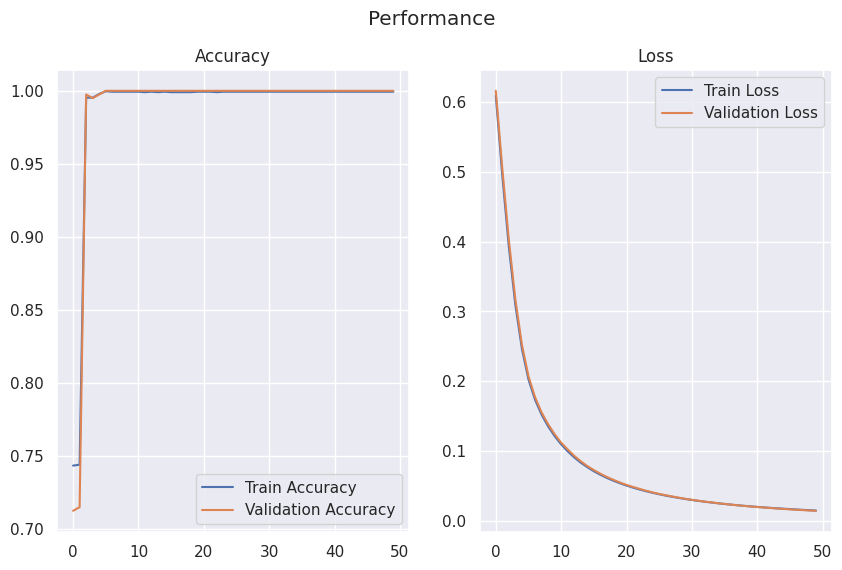

In [ ]:
Train(model, device, criterion, optimizer, num_epochs)

## Cheking model performance after training

In [ ]:
# Check accuracy on training & test
print(f"Accuracy on training set: {get_acc(train_loader, model)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model)*100:.2f}")

Accuracy on training set: 99.94
Accuracy on training set: 100.00
Accuracy on test set: 100.00


In [ ]:
model.eval()
with torch.no_grad():
    # Loop through the data
    for c, (x, y) in enumerate(test_loader):
      if c == 0:
          # Move data to device
          x = x.to(device=device)
          y = y.to(device=device)

          # Forward pass
          logits = model(x)
          _, predictions = logits.max(1)

          print("---------------------------- Labels ----------------------------")
          print(y)
          print("---------------------------- Predictions ----------------------------")
          print(predictions)
      else:
          break

---------------------------- Labels ----------------------------
tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0])
---------------------------- Predictions ----------------------------
tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0])


In [ ]:
model.eval()
with torch.no_grad():
    # Loop through the data
    for c, (x, y) in enumerate(test_loader):
      # Move data to device
      x = x.to(device=device)
      y = y.to(device=device)

      # Forward pass
      logits = model(x)
      _, predictions = logits.max(1)

      if torch.all(y == predictions).item():
        print("All Predictions and Labels in current mini-batch of test dataset are completely.")
      # print(torch.all(y == predictions))

All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.
All Predictions and Labels in current mini-batch of test dataset are completely.


Accuracy Of Model On Test Data Is :  tensor(100.)
Percision Of Model On Test Data Is :  tensor(100.)
Recall Of Model On Test Data Is :  tensor(100.)
F1-Score Of Model On Test Data Is :  tensor(100.)

Confusion Matrix Of Model On Test Data Is : 


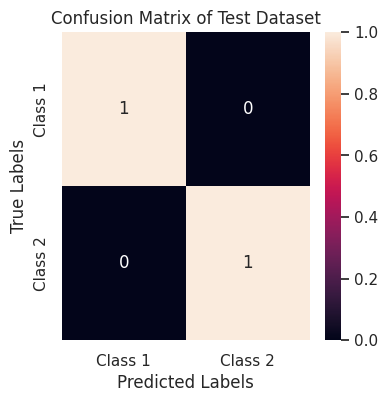

In [ ]:
predictions = torch.zeros(len(test_set))
targets = torch.zeros(len(test_set))
pointer = 0

model.eval()
with torch.no_grad():
  for x, y in test_loader:
    logits = model(x)
    _, preds = logits.max(1)
    predictions[pointer: pointer+x.shape[0]] = preds
    targets[pointer: pointer+x.shape[0]] = y
    pointer+=x.shape[0]


  accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=2)
  precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=2)
  recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=2)
  f1score = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=2)
  confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=2)

  a = accuracy(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  p = precision(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  r = recall(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  f1s = f1score(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  cm = confmat(predictions, targets.reshape(-1,).to(dtype=torch.int64))


  print("Accuracy Of Model On Test Data Is : ", 100*a)
  print("Percision Of Model On Test Data Is : ", 100*p)
  print("Recall Of Model On Test Data Is : ", 100*r)
  print("F1-Score Of Model On Test Data Is : ", 100*f1s)
  print("")

  print("Confusion Matrix Of Model On Test Data Is : ")
  cm = cm/cm.sum(dim=1).reshape(2,1)
  plt.figure(figsize = (4, 4))
  sn.heatmap(cm, annot=True, xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title("Confusion Matrix of Test Dataset")
  plt.show()